## Project: Grade distribution analysis of UW Madison dataset


### Data collection

### Problem formulation
* What is the influence of an instructor on A-grades fraction?
* What is the influence of class size on A-grades fraction?
* Where bimodality comes from? Is it a class size? 
* What is the A-grades fraction distribution for a specific instructor with respect to the class size?

In [142]:
#import libraries
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import scipy.stats as stats
from statistics import stdev
import statsmodels.api as sm

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 1.8)

import warnings
#warnings.SettingWithCopyWarning
pd.options.mode.chained_assignment = None
#FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [114]:
#define necessary functions

def dist_plot(x,_xlim,_xlabel,_bins,**kwargs):
    """Plots combined sns.distplot with sns.boxplot
    together with cdf"""
    fig, (ax, ax3) = plt.subplots(1,2,figsize=(12,4))
    
    sns.distplot(x, bins=_bins, hist_kws=dict(alpha=0.4),
                      kde_kws=dict(linewidth=3),ax=ax)
    ax2 = ax.twinx()
    sns.boxplot(x=x, ax=ax2, showfliers=False,linewidth=3)
    ax2.set(ylim=(-5, 5),xlim=_xlim)
    ax2.yaxis.set_ticks_position('none') 
        
    #label axes
    ax.set_xlabel(_xlabel)
    ax.set_ylabel('Distribution')
    
    #add cumulative distribution plot
    sns.distplot(x, bins=_bins, hist_kws=dict(alpha=0.4,cumulative=True),
                      kde_kws=dict(linewidth=3,cumulative=True),ax=ax3)
    #label axes
    ax3.set_xlabel(_xlabel)
    ax3.set_ylabel('Cumulative distribution')
    ax3.set_xlim(_xlim)
    
def summary_text(s,class_ave,p):
    """Takes series s and returns
    text with summary statistics"""
    #calculate the 5-point statistics
    d = s.describe()
    return '$\widebar{x}$ = ' + str(round(d[1],2)) + '\n' \
                  + '$\widetilde{x}$ = ' + str(round(d[5],2)) + '\n' \
                  + '$s$ = ' + str(round(d[2],2)) + '\n' \
                  + '$n$ = ' + str(int(d[0])) + '\n' \
                  + '$\widebar{class}$ = ' + str(int(class_ave)) + '\n' \
                  + '$p$ = ' + "{:.2E}".format(p)
    
    
def plot_dist_instructor(filter_id,df,ax,popmean):
    """Plot A-fraction distribution 
    for a given instructor on top of 
    population distribution"""
    
    #select the subset of data belonging to an instructor
    ser = df.loc[filter_id,'a_frac']
    #calculate average class size
    class_ave = df.loc[filter_id,'class_size'].mean()    
    #compare mean of an instructor with population mean via t-test
    stat, p = stats.ttest_1samp(ser,popmean=popmean)
    
    #seaborn distribution plot
    sns.distplot(ser, ax=ax, bins=np.linspace(0,1,15),color='blue',kde_kws={"lw": 3})
    
    #set the limits
    ax.set_xlim(-0.45,1.0)
    ax.set_ylim(0,6)
    
    #calculate summary statistics and display it
    summary = summary_text(ser,class_ave,p)
    #text coordinates
    x_loc = -0.4
    y_loc = ax.get_ylim()[1]*0.65
    #print text on the plot
    ax.text(x_loc, y_loc, summary, bbox=dict(facecolor='white',
                                             ls='-',lw=1,alpha=1),fontsize=17)
    
def plot_dist_instructor_all(df,instructor_ids,figname):
    """plots A-fraction distribution for top 8 instructors"""
    #calculate the population mean
    popmean = df.a_frac.mean()
    
    #plot top 8 binstructors
    fig, axes = plt.subplots(2,4,figsize=(20,12))

    for i in range(8):
        #select the subplot location
        row = i//4
        col = i%4
        ax = axes[row, col]
        
        #select an instructor
        _id = instructor_ids[i]
        #filter for a given instructor
        filter_id = (df.instructor_id == _id)

        #plot distribution for instructor and for all population
        plot_dist_instructor(filter_id,df,ax,popmean)
        sns.distplot(df.a_frac, ax=ax, bins=15,hist=False,color='red',kde_kws={"lw": 3})  
        ax.set_title(df.loc[df.instructor_id == _id,'instructor_name'].iloc[0])

    plt.tight_layout()
    fig.savefig(figname)
    
def perc_25(x):
    return np.percentile(x, q = [25])
def perc_75(x):
    return np.percentile(x, q = [75])

def table_Q123(df,group_col,comp_col):
    #display a summary table with quantiles
    table = df.groupby(group_col)[comp_col].agg([perc_25,np.median,perc_75]).round(2)
    table.index.names = ['budget']
    table.rename(columns={'perc_25':'Q1','median':'Q2 (median)','perc_75':'Q3'},inplace=True)
    return table

In [143]:
#read the processed dataset
df = pd.read_csv('grades_processed.csv')

#define category
cat_type = CategoricalDtype(categories=["small", "medium", "large"],ordered=True)
df.class_cat = df.class_cat.astype(cat_type)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74853 entries, 0 to 74852
Data columns (total 12 columns):
Unnamed: 0              74853 non-null int64
course_offering_uuid    74853 non-null object
section_uuid            74853 non-null object
section_number          74853 non-null int64
instructor_id           74853 non-null int64
instructor_name         74853 non-null object
subject_code            74853 non-null int64
subject_name            74853 non-null object
is_stem                 74853 non-null int64
class_size              74853 non-null int64
class_cat               74853 non-null category
a_frac                  74853 non-null float64
dtypes: category(1), float64(1), int64(6), object(4)
memory usage: 6.4+ MB


In [4]:
#short summary of object columns
df.describe(include=['object'])

,course_offering_uuid,section_uuid,instructor_name,subject_name,class_cat
count,74853,74853,74853,74853,74853
unique,47812,74853,10133,190,3
top,35a65d4a-702c-388e-b98b-a0127e587f16,e3742aa7-1ee5-385c-8952-32526cefd78d,MARK ALLIE,Spanish (Spanish and Portuguese),medium
freq,60,1,239,2738,36955


In [5]:
#short summary of numeric columns
df[['is_stem','class_size','a_frac']].describe()

,is_stem,class_size,a_frac
count,74853.000000,74853.000000,74853.000000
mean,0.405675,31.582902,0.557330
std,0.491025,45.922572,0.306278
min,0.000000,1.000000,0.000000
25%,0.000000,11.000000,0.285714
50%,0.000000,18.000000,0.529412
75%,1.000000,29.000000,0.857143
max,1.000000,717.000000,1.000000


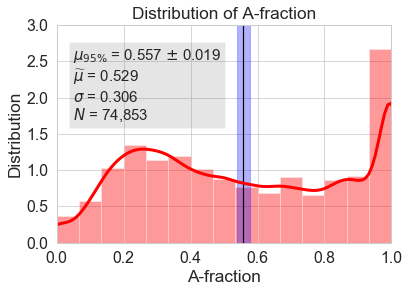

In [100]:
##plot the distribution of A-fraction for all courses
ax = sns.distplot(df.a_frac, bins=15,color='red',kde_kws={"lw": 3})

#label the axes
ax.set_ylabel('Distribution')
ax.set_xlabel('A-fraction')
#set limits
ax.set(ylim=(0,3),xlim=(0,1))
ax.set_title('Distribution of A-fraction')

#calculate the mean 
m = df.a_frac.mean()
med = df.a_frac.median()
s = df.a_frac.std()

#calculate the confidence interval using t-statistics
#since the std of the whole population is unknown
m0, m1 = stats.t.interval(alpha = 0.05,                     # Confidence level
                 df= df.shape[0]-1,                         # Degrees of freedom
                 loc = df.a_frac.mean(),                    # Sample mean
                 scale = stdev(df.a_frac))                  # Standard deviation estimate

#add mean and confidence interval to the plot
ax.vlines(m,0,3)
ax.axvspan(m0, m1, alpha=0.3, color='blue')

#add text with summary statistics to the plot
summary = '$\mu_{95\%}$' + ' = {} $\pm$ {}'.format(round(m,3), round(m-m0,3)) + '\n' \
          '$\widetilde\mu$ = {} '.format(round(med,3)) + '\n' \
          '$\sigma$ = {} '.format(round(s,3)) + '\n' \
          '$N$ = {:,} '.format(df.shape[0])
_ = ax.text(0.05,1.7,summary,fontsize=15,
        bbox=dict(facecolor='grey', alpha=0.2))

KstestResult(statistic=0.5030702257501721, pvalue=0.0)

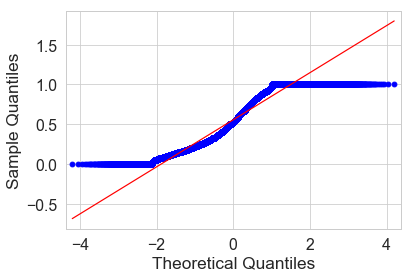

In [226]:
#distribution is clearly not normal, it is bimodal
#do the test for normality: Q-Q plot
fig = sm.qqplot(df.a_frac,line='r')
stats.kstest(df.a_frac, 'norm')


The first question: what is the influence of an instructor on A-grades fraction?
But first let's explore the dataset with regards to instructors.
How many classes one instructor taught?

,count,mean,std,min,25%,50%,75%,max
# of classes taught by instructor,10165.0,7.363797,10.609767,1.0,1.0,3.0,9.0,239.0


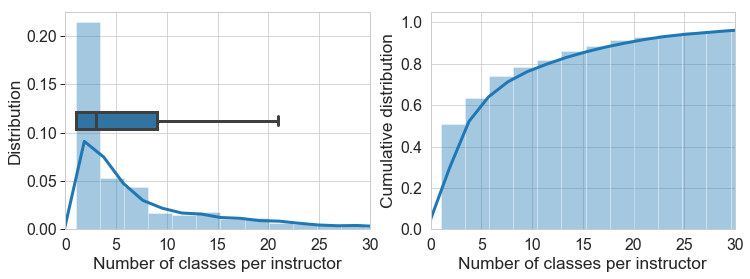

In [44]:
#group by instructor
df_inst_count = df.groupby('instructor_id')['section_uuid'].count()
#combine distplot and boxplot
dist_plot(df_inst_count,_xlim=(0,30),
          _xlabel='Number of classes per instructor',_bins=100)
#add the summary table
pd.DataFrame(df_inst_count).describe()\
  .rename(columns={'section_uuid':'# of classes taught by instructor'}).T

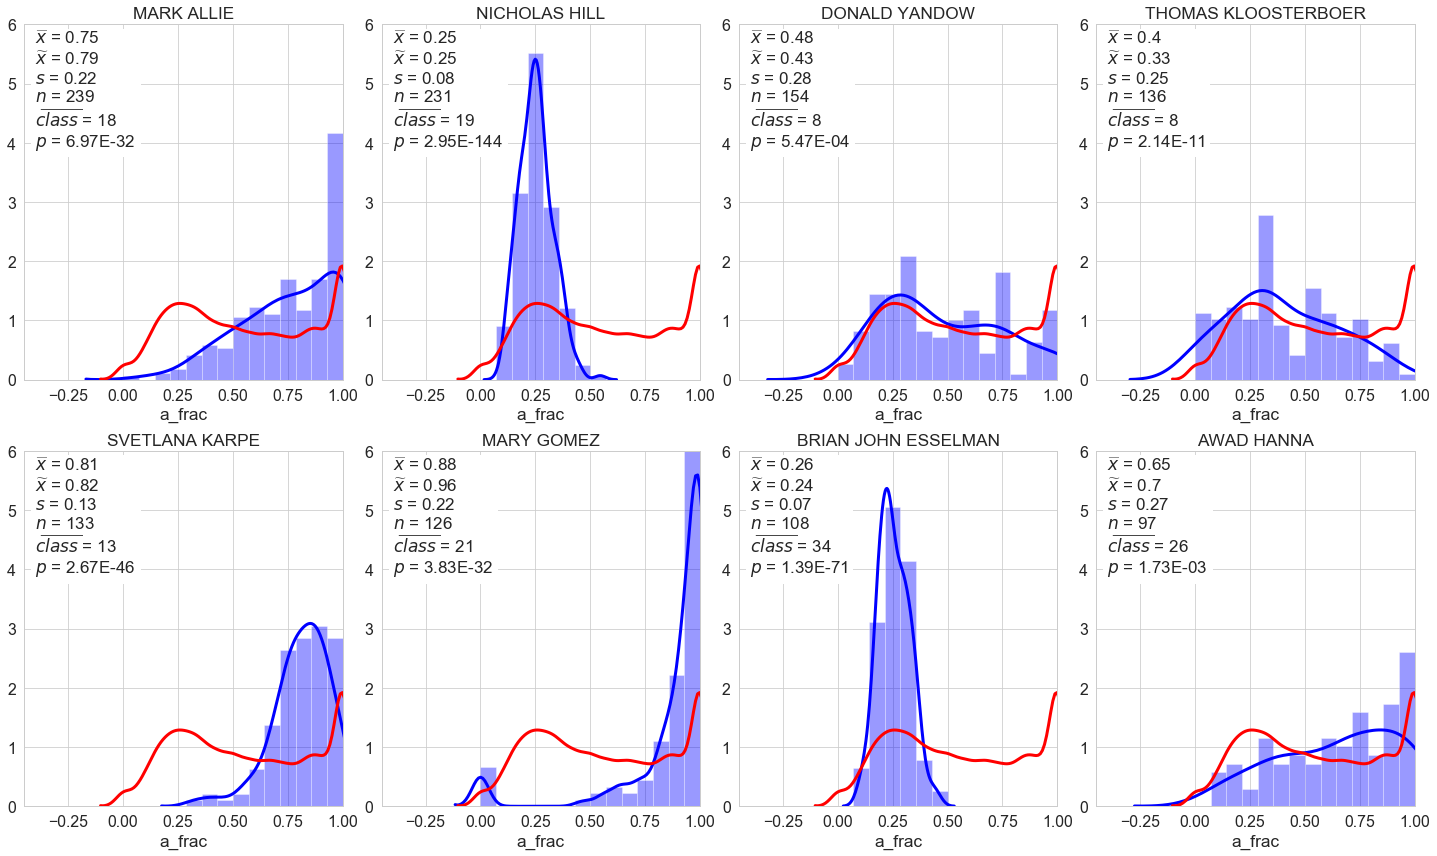

In [115]:
plot_dist_instructor_all(df, instructor_ids = \
                         df_inst_count.sort_values(ascending=False).index[:8])

All top instructors form different groups, as confirmed by t-test with p-values less than 0.05.

,count,mean,std,min,25%,50%,75%,max
class size,74853.0,31.582902,45.922572,1.0,11.0,18.0,29.0,717.0


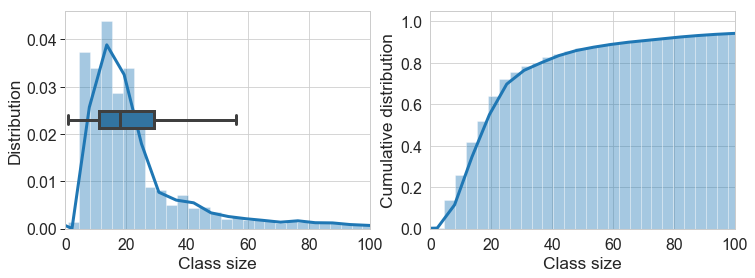

In [93]:
#What is the class size distribution?
#combine distplot and boxplot
dist_plot(df.class_size,_xlim=(0,100),
          _xlabel='Class size',_bins=200)

#add the summary table
pd.DataFrame(df.class_size).describe()\
  .rename(columns={'class_size':'class size'}).T

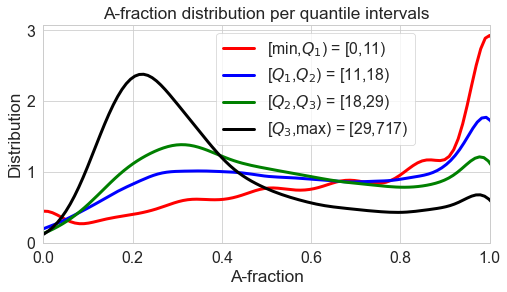

In [111]:
#How to group the class sizes?
#find quanlile boundaries
q = df.class_size.quantile(q=[0,0.25,0.5,0.75,1])
q[0] = 0
#define colors and labels
colors = ['r','b','g','k']
labels = ['min','$Q_1$','$Q_2$','$Q_3$','max']

#Decide what class size to include:
fig, ax = plt.subplots(1,1,figsize=(8,4))

#plot kde lines together
for i in range(4):
    filter_id = (df.class_size >= q.values[i]) & (df.class_size < q.values[i+1])
    ser = df.loc[filter_id,'a_frac']

    sns.distplot(ser, ax=ax, bins=np.linspace(0,1,15),color=colors[i],hist=False,
                 kde_kws={"lw": 3},label='[{},{}) = [{},{})'\
                 .format(labels[i],labels[i+1],int(q.values[i]),int(q.values[i+1])))
    ax.legend()

ax.set(xlim=(0,1))
ax.set_ylabel('Distribution')
ax.set_xlabel('A-fraction')
ax.legend(loc='upper right', bbox_to_anchor=(0.85,1))
_ = ax.set_title('A-fraction distribution per quantile intervals')

,Q1,Q2 (median),Q3
budget,,,
small,0.45,0.78,1.00
medium,0.32,0.54,0.83
large,0.21,0.31,0.55


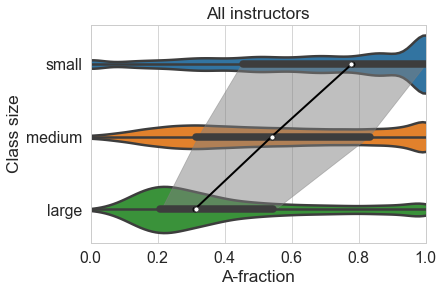

In [149]:
#Define three groups by size: small, medium, large
#plot the different groups

t = table_Q123(df, group_col='class_cat', comp_col='a_frac').dropna(axis=0)

ax = sns.violinplot(x='a_frac', y='class_cat',data=df,linewidth=2.5)
ax.plot(list(t['Q2 (median)'].values),[0,1,2],'ko-',linewidth=2)
ax.fill_betweenx([0,1,2],t.Q1.values,t.Q3.values,alpha=0.5,color='grey')

ax.set(xlabel='A-fraction',ylabel='Class size')
ax.set_title('All instructors')
ax.set_xlim(0,1)

display(t)

Do the The Kruskal-Wallis H-test that tests the null hypothesis that the population median of all of the groups are equal. 

In [117]:
#test for overall size dependence
small = df.loc[df.class_cat == 'small','a_frac']
medium = df.loc[df.class_cat == 'medium','a_frac']
large = df.loc[df.class_cat == 'large','a_frac']
    
stats.kruskal(small,medium,large)

KruskalResult(statistic=8906.607441196318, pvalue=0.0)

where statistics is Kruskal-Wallis H statistic and the p-value was calculated for the test using the assumption that H has a chi square distribution.
The test comfirms that different class sizes form different groups. Does it changes from instructor to instructor?

In [242]:
#find instructors with most even distribution with 
#regard to class sizes taught having most classes taught
df_u = df.groupby(['instructor_id','class_cat'])['section_uuid']\
               .count().unstack(level=1).fillna(0).astype('int64')

#change categorical to str type 
#to be able to add columns
df_u.columns = df_u.columns.astype('str')

df_u.columns.name = None

#add instructor names
df_u['instructor_name'] = df_u.index.map(lambda x: 
                                         df.loc[(df.instructor_id == x),
                                                'instructor_name'].iloc[0])
#rearrange
df_u = df_u[['instructor_name','small','medium','large']]
#add total classes taught
df_u['total'] = df_u.sum(axis=1)
#introduce metric to maximaze
df_u['compare'] = df_u.small * df_u.medium * df_u.large / df_u.total**2
#sort values to maximaze metric
df_u.sort_values(by='compare',ascending=False)[:10]

,instructor_name,small,medium,large,total,compare
instructor_id,,,,,,
566960,MARK ALLIE,67,142,30,239,4.996761
2601535,JAMES SMITH,24,27,21,72,2.625000
4197306,SCOTT TEEPLE,32,17,30,79,2.614966
3615604,KELLI RICHARDS,13,38,27,78,2.192308
984470,ANDREW WINTERSTEIN,20,35,15,70,2.142857
685141,CATON ROBERTS,38,35,11,84,2.073413
886751,SCOTT MELLOR,19,20,17,56,2.059949
464468,MONICA THEIS,12,35,24,71,1.999603
2601502,AWAD HANNA,11,56,30,97,1.964077


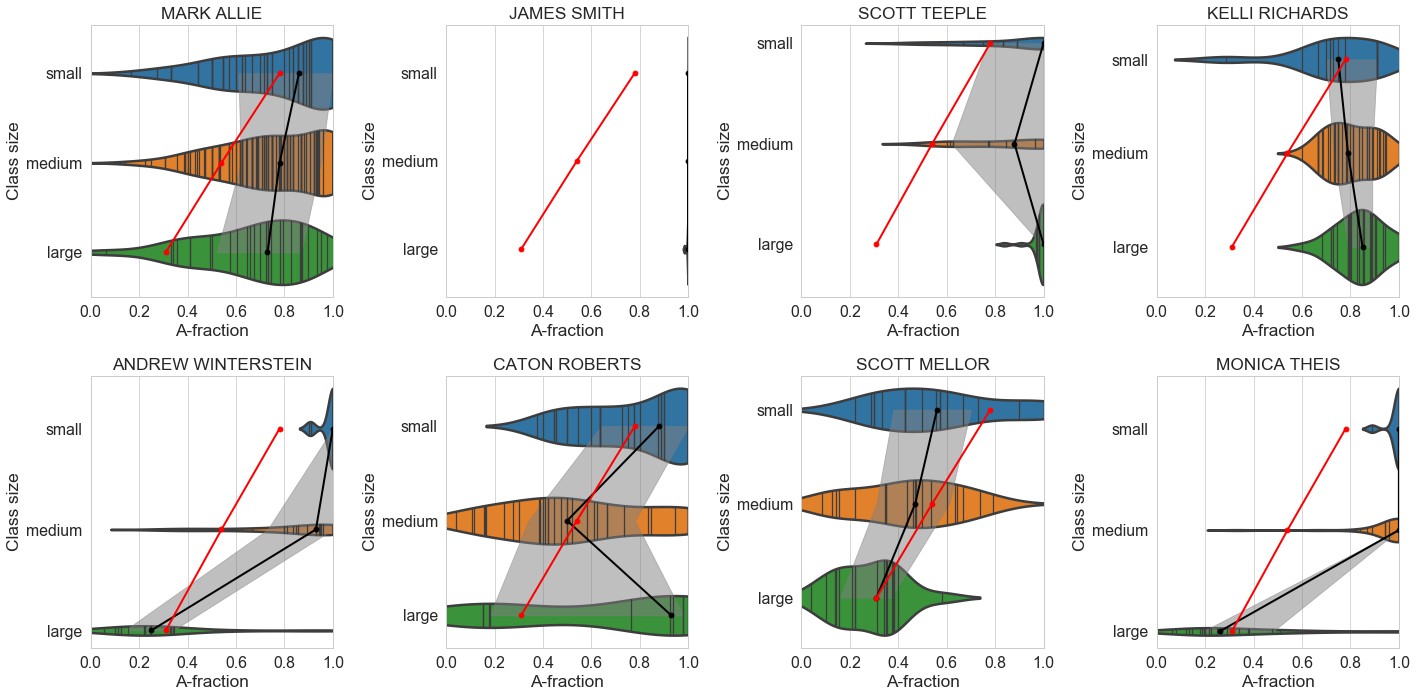

In [231]:
#quantile values for population
t0 = table_Q123(df, group_col='class_cat', 
               comp_col='a_frac').dropna(axis=0)

#plot top 8 binstructors
fig, axes = plt.subplots(2,4,figsize=(20,10))

for i in range(8):
    #select the subplot location
    row = i//4
    col = i%4
    ax = axes[row, col]
            
    df_single = df[(df.instructor_id == u_id[i])]
    t = table_Q123(df_single, group_col='class_cat', 
               comp_col='a_frac').dropna(axis=0)
    
    sns.violinplot(x='a_frac', y='class_cat',data=df_single,
                   inner='stick',linewidth=2.5,ax=ax)
    #add median lines
    ax.plot(list(t['Q2 (median)'].values),[0,1,2],'ko-',linewidth=2)
    ax.plot(list(t0['Q2 (median)'].values),[0,1,2],'ro-',linewidth=2)
    ax.fill_betweenx([0,1,2],t.Q1.values,t.Q3.values,alpha=0.5,color='grey')
    #set title and limits
    ax.set_title(df.loc[df.instructor_id == u_id[i],'instructor_name'].iloc[0])
    ax.set_xlim(0,1)
    ax.set(xlabel='A-fraction',ylabel='Class size')

plt.tight_layout()

fig.savefig('instuctor_uniform_max.png')

The total number of instructors is 10165 , select 247 instructors with threshold = 5 , median = 9.33


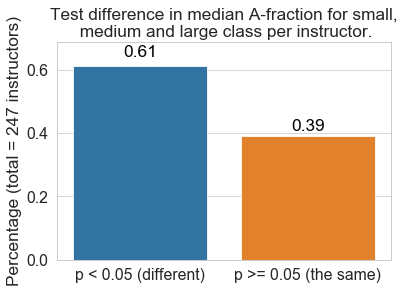

In [187]:
#define threshold for smallest number of classes per category
th = 5
#filter with valuer lower than threshold
fiter_th = (df_u.small < th) | \
          (df_u.medium < th) | \
          (df_u.large < th)

#find instructor ids
u_id = df_u[~fiter_th].sort_values(by='compare',ascending=False).index


#calculate median for top instructors with the most 
#uniformly distributed class sizes and most sections taught
num = u_id.shape[0]
p_3 = np.zeros(num)
krusk_3 = np.zeros(num)

for i in range(num):
    #filter specific instructor
    df_filter = df.instructor_id == u_id[i]
    #calculate the p-value for non-parametric ANOVA test
    df_c = df[df_filter]
    krusk_3[i], p_3[i] = stats.kruskal(df_c.loc[df_c.class_cat=='small','a_frac'],
                                   df_c.loc[df_c.class_cat=='medium','a_frac'],
                                   df_c.loc[df_c.class_cat=='large','a_frac'])

fig, ax = plt.subplots(1,1,figsize=(6,4))

y = [p_3[p_3 < 0.05].shape[0]/num, p_3[p_3 >= 0.05].shape[0]/num]
x = ['p < 0.05 (different)','p >= 0.05 (the same)']

sns.barplot(x = x, y = y, ax=ax)

#add text
for i in range(len(x)):
    ax.text(i,y[i]*1.05, round(y[i],2), color='black', ha="center")

ax.set(ylabel='Percentage (total = {} instructors)'.format(num))
ax.set_title('Test difference in median A-fraction for small,\n medium and large class per instructor.')
ax.set_ylim(0,ax.get_ylim()[1]*1.07)

#print summary about filtering
print('The total number of instructors is', df_u.shape[0],
      ', select',u_id.shape[0],'instructors with threshold =',th,
     ', median =',df_u.loc[u_id,'total'].div(3).median().round(2))

Concusion: about 61% of instructors grade classes of different sizes differently.

a_frac
is_stem class_cat          
0       small      0.750000
        medium     0.571429
        large      0.351351
1       small      0.833333
        medium     0.500000
        large      0.285714

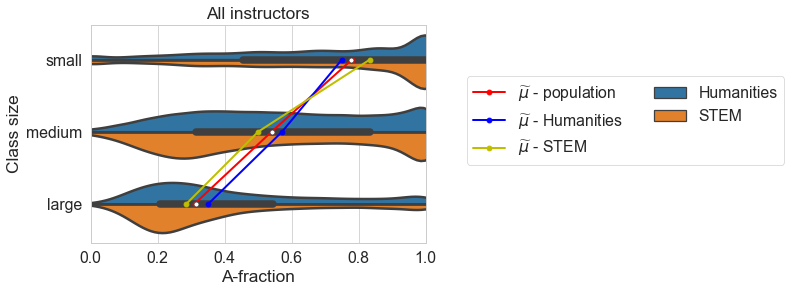

In [230]:
#effect of STEM vs social

ax = sns.violinplot(x='a_frac', y='class_cat',hue='is_stem',
                    data=df,linewidth=2.5,split=True)
#ax.fill_betweenx([0,1,2],t.Q1.values,t.Q3.values,alpha=0.5,color='grey')

ax.plot(list(t0['Q2 (median)'].values),[0,1,2],'ro-',linewidth=2,label='pop median')
ax.plot(list(t_stem.loc[0].values),[0,1,2],'bo-',linewidth=2,label='Humanities median')
ax.plot(list(t_stem.loc[1].values),[0,1,2],'yo-',linewidth=2,label='STEM median')


ax.set(xlabel='A-fraction',ylabel='Class size')
ax.set_title('All instructors')
ax.set_xlim(0,1)
ax.legend(bbox_to_anchor=[1.1,0.8],ncol=2)

new_labels = ['$\widetilde{\mu}$ - population',
              '$\widetilde{\mu}$ - Humanities', 
              '$\widetilde{\mu}$ - STEM','Humanities', 'STEM']
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

t_stem = df.groupby(['is_stem','class_cat'])[['a_frac']].median()
display(t_stem)

In [209]:
#test difference between STEM/Humanities within group size

krusk_s, p_s = stats.kruskal(df.loc[(df.is_stem==0)&(df.class_cat=='small'),'a_frac'],
                             df.loc[(df.is_stem==1)&(df.class_cat=='small'),'a_frac'])

krusk_m, p_m = stats.kruskal(df.loc[(df.is_stem==0)&(df.class_cat=='medium'),'a_frac'],
                             df.loc[(df.is_stem==1)&(df.class_cat=='medium'),'a_frac'])

krusk_l, p_l = stats.kruskal(df.loc[(df.is_stem==0)&(df.class_cat=='large'),'a_frac'],
                             df.loc[(df.is_stem==1)&(df.class_cat=='large'),'a_frac'])

print(p_s,p_m,p_l)

1.243842542869489e-21 1.3426008723578274e-19 4.983152120819241e-65
